## Download Dataset from here:

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp


Emotion_Detection_Data/
├── train.txt
├── val.txt
└── test.txt

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

In [2]:
# Load and process data

def load_data(path):
    with open(path, encoding="utf-8") as f:
        lines = f.read().splitlines()
    texts, labels = zip(*(line.split(";") for line in lines))
    return list(texts), list(labels)

train_texts, train_labels = load_data("Emotion_Detection_Data/train.txt")
val_texts, val_labels = load_data("Emotion_Detection_Data/val.txt")
test_texts, test_labels = load_data("Emotion_Detection_Data/test.txt")

def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

all_texts = train_texts + val_texts + test_texts
vocab_counter = Counter(word for text in all_texts for word in tokenize(text))
vocab = {word: idx+2 for idx, (word, _) in enumerate(vocab_counter.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode_text(text, max_len=50):
    tokens = tokenize(text)
    ids = [vocab.get(t, 1) for t in tokens][:max_len]
    return ids + [0] * (max_len - len(ids)), min(len(ids), max_len)

label_enc = LabelEncoder()
label_enc.fit(train_labels)
num_classes = len(label_enc.classes_)

In [3]:
# Dataset with sequence lengths

class EmotionDataset(Dataset):
    def __init__(self, texts, labels):
        encoded = [encode_text(t) for t in texts]
        self.x = torch.tensor([e[0] for e in encoded], dtype=torch.long)
        self.lengths = torch.tensor([e[1] for e in encoded], dtype=torch.long)
        self.y = torch.tensor(label_enc.transform(labels), dtype=torch.long)

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.lengths[idx], self.y[idx]

train_ds = EmotionDataset(train_texts, train_labels)
val_ds = EmotionDataset(val_texts, val_labels)
test_ds = EmotionDataset(test_texts, test_labels)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [4]:
# Model

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)
        return self.fc(self.dropout(hidden[-1]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(len(vocab), embed_dim=128, hidden_dim=128, output_dim=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

In [5]:
# Train

train_accs, val_accs = [], []
best_val = 0
patience, wait = 5, 0

for epoch in range(30):
    model.train()
    total, correct = 0, 0
    for x, l, y in train_loader:
        x, l, y = x.to(device), l.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x, l)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        preds = output.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    train_acc = correct / total
    train_accs.append(train_acc)

    # Validation
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for x, l, y in val_loader:
            x, l, y = x.to(device), l.to(device), y.to(device)
            preds = model(x, l).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    scheduler.step(1 - val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

Epoch 1: Train Acc=0.5453, Val Acc=0.8190
Epoch 2: Train Acc=0.8733, Val Acc=0.8905
Epoch 3: Train Acc=0.9343, Val Acc=0.9070
Epoch 4: Train Acc=0.9580, Val Acc=0.8630
Epoch 5: Train Acc=0.9693, Val Acc=0.9185
Epoch 6: Train Acc=0.9792, Val Acc=0.9150
Epoch 7: Train Acc=0.9833, Val Acc=0.9170
Epoch 8: Train Acc=0.9856, Val Acc=0.9145
Epoch 9: Train Acc=0.9908, Val Acc=0.9160
Epoch 10: Train Acc=0.9920, Val Acc=0.9135
Early stopping.


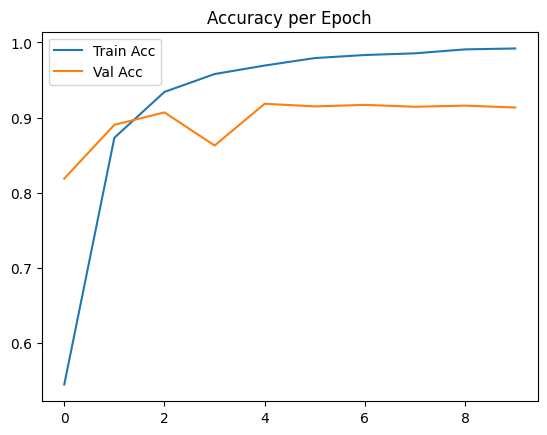

In [6]:
# Plot accuracy

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()

In [7]:
# Test evaluation

model.load_state_dict(torch.load("best_model.pt"))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, l, y in test_loader:
        x, l = x.to(device), l.to(device)
        preds = model(x, l).argmax(1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(y.tolist())

print(classification_report(y_true, y_pred, target_names=label_enc.classes_))

              precision    recall  f1-score   support

       anger       0.91      0.90      0.90       275
        fear       0.86      0.87      0.86       224
         joy       0.94      0.91      0.93       695
        love       0.76      0.84      0.79       159
     sadness       0.96      0.95      0.96       581
    surprise       0.68      0.76      0.71        66

    accuracy                           0.91      2000
   macro avg       0.85      0.87      0.86      2000
weighted avg       0.91      0.91      0.91      2000



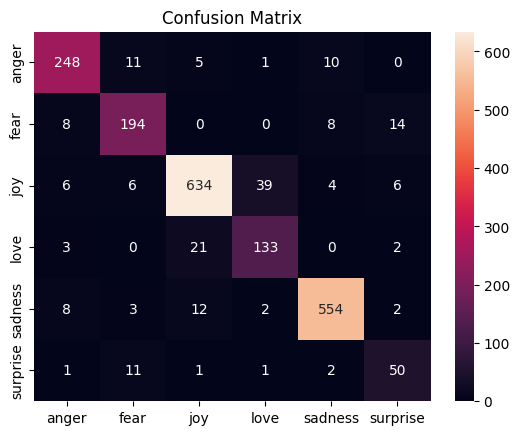

In [8]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.title("Confusion Matrix")
plt.show()